In [1]:
## necessary imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow

C:\Users\abhin\anaconda3\envs\nlp_course\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\abhin\anaconda3\envs\nlp_course\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\abhin\anaconda3\envs\nlp_course\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\abhin\anaconda3\envs\nlp_course\lib\site-packages

In [2]:
## loading the train and the test sets

train = pd.read_csv('Google_Stock_Price_Train.csv', usecols=['Date', 'Open']) ## Open -> opening stock price for the day
test = pd.read_csv('Google_Stock_Price_Test.csv', usecols=['Date', 'Open'])

## 'Date': str --> datetime, set as index

train['Date'] = train['Date'].apply(lambda str_date: pd.to_datetime(str_date))
train.set_index('Date', inplace=True)

test['Date'] = test['Date'].apply(lambda str_date: pd.to_datetime(str_date))
test.set_index('Date', inplace=True)

In [3]:
train.head()

,Open
Date,
2012-01-03,325.25
2012-01-04,331.27
2012-01-05,329.83
2012-01-06,328.34
2012-01-09,322.04


In [4]:
test.head()

,Open
Date,
2017-01-03,778.81
2017-01-04,788.36
2017-01-05,786.08
2017-01-06,795.26
2017-01-09,806.40


In [5]:
train.shape

(1258, 1)

In [6]:
test.shape

(20, 1)

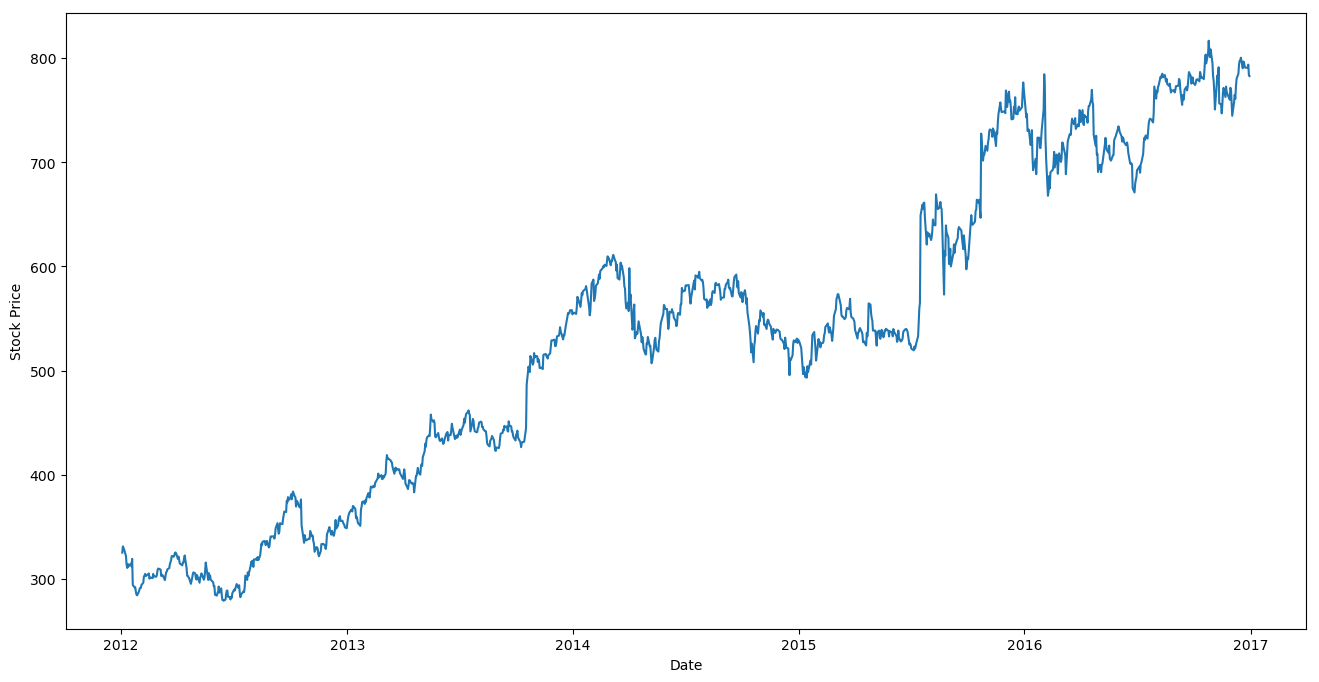

In [7]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(16,8))
ax.plot(train['Open'])
ax.set_xlabel('Date')
ax.set_ylabel('Stock Price')

plt.show()

In [8]:
## normalization

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))

scaler.fit(train)
scaled_train_data = scaler.transform(train)

In [9]:
## time steps --> no. of previous values as input to LSTM to make predictions
## time_steps = 120 (feel free to experiment with different values)

time_steps = 120

In [10]:
## feature label split

X = list()
y = list()

for i in range(time_steps, len(scaled_train_data)):
    X.append(scaled_train_data[i-time_steps:i,0].reshape(time_steps))
    y.append(scaled_train_data[i,0])
    
X, y = np.array(X), np.array(y)

## ADDING A NEW DIMESION TO X_TRAIN

## TWO REASONS:
## ONE --> KERAS RNN LAYERS NEED AN INPUT OF DIMESION (BATCH_SIZE, TIMESTEPS, INPUT_DIM), INPUT_DIM --> NO. OF PREDICTORS
## TWO --> IT ENABLES US TO ADD OTHER PREDICTORS FOR TRAINING. E.G., STOCK PRICES FOR SIMILAR TECH COMPANIES

X = np.reshape(X, (X.shape[0], X.shape[1], 1))

## train validation split

from sklearn.model_selection import train_test_split

X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=27)

In [11]:
X_train.shape

(910, 120, 1)

In [12]:
X_validation.shape

(228, 120, 1)

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [14]:
## initialization
regressor = Sequential()

## LSTM 1
regressor.add(LSTM(units=X_train.shape[1], input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
regressor.add(Dropout(rate=0.2)) ## turns off 20% perceptrons during training to prevent overfitting

## LSTM 2
regressor.add(LSTM(units=X_train.shape[1], return_sequences=True))
regressor.add(Dropout(rate=0.2)) ## turns off 20% perceptrons during training to prevent overfitting

## LSTM 3
regressor.add(LSTM(units=X_train.shape[1], return_sequences=True))
regressor.add(Dropout(rate=0.2)) ## turns off 20% perceptrons during training to prevent overfitting

## LSTM 4
regressor.add(LSTM(units=X_train.shape[1], return_sequences=True))
regressor.add(Dropout(rate=0.2)) ## turns off 20% perceptrons during training to prevent overfitting

## LSTM 5
regressor.add(LSTM(units=X_train.shape[1]))
regressor.add(Dropout(rate=0.2)) ## turns off 20% perceptrons during training to prevent overfitting

## Output
regressor.add(Dense(units=1))

## Compile
regressor.compile(optimizer='adam', loss='mean_squared_error')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [15]:
## model fit
history = regressor.fit(x=X_train, y=y_train, batch_size=32, epochs=300, validation_data=[X_validation, y_validation])

Train on 910 samples, validate on 228 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/300
910/910 [==============================] - 34s 37ms/sample - loss: 0.0341 - val_loss: 0.0042
Epoch 2/300
910/910 [==============================] - 33s 37ms/sample - loss: 0.0045 - val_loss: 0.0021
Epoch 3/300
910/910 [==============================] - 37s 41ms/sample - loss: 0.0055 - val_loss: 0.0036
Epoch 4/300
910/910 [==============================] - 38s 42ms/sample - loss: 0.0049 - val_loss: 0.0023
Epoch 5/300
910/910 [==============================] - 38s 42ms/sample - loss: 0.0059 - val_loss: 0.0022
Epoch 6/300
910/910 [==============================] - 39s 43ms/sample - loss: 0.0040 - val_loss: 0.0019
Epoch 7/300
910/910 [==============================] - 39s 43ms/sample - loss: 0.0040 - val_loss: 0.0030
Epoch 8/300
910/910 [==============================] - 41s 45ms/sample - loss: 0.0037 - val_loss: 0.0016
Epoch 9/300
910/910 [==============================] - 43s 47ms/sa

910/910 [==============================] - 28s 30ms/sample - loss: 0.0016 - val_loss: 0.0011
Epoch 75/300
910/910 [==============================] - 27s 30ms/sample - loss: 0.0017 - val_loss: 4.2135e-04
Epoch 76/300
910/910 [==============================] - 27s 29ms/sample - loss: 0.0013 - val_loss: 3.4580e-04
Epoch 77/300
910/910 [==============================] - 28s 31ms/sample - loss: 0.0016 - val_loss: 3.4411e-04
Epoch 78/300
910/910 [==============================] - 30s 33ms/sample - loss: 0.0014 - val_loss: 3.4795e-04
Epoch 79/300
910/910 [==============================] - 27s 30ms/sample - loss: 0.0013 - val_loss: 3.5453e-04
Epoch 80/300
910/910 [==============================] - 27s 29ms/sample - loss: 0.0016 - val_loss: 6.9580e-04
Epoch 81/300
910/910 [==============================] - 27s 30ms/sample - loss: 0.0016 - val_loss: 3.4420e-04
Epoch 82/300
910/910 [==============================] - 28s 31ms/sample - loss: 0.0015 - val_loss: 5.9522e-04
Epoch 83/300
910/910 [=====

910/910 [==============================] - 27s 29ms/sample - loss: 0.0011 - val_loss: 2.1655e-04
Epoch 149/300
910/910 [==============================] - 27s 30ms/sample - loss: 9.7011e-04 - val_loss: 4.5673e-04
Epoch 150/300
910/910 [==============================] - 28s 31ms/sample - loss: 0.0011 - val_loss: 2.6323e-04
Epoch 151/300
910/910 [==============================] - 32s 35ms/sample - loss: 9.0956e-04 - val_loss: 3.0340e-04
Epoch 152/300
910/910 [==============================] - 30s 33ms/sample - loss: 0.0010 - val_loss: 0.0012
Epoch 153/300
910/910 [==============================] - 32s 35ms/sample - loss: 0.0013 - val_loss: 7.7651e-04
Epoch 154/300
910/910 [==============================] - 31s 34ms/sample - loss: 0.0012 - val_loss: 2.0327e-04
Epoch 155/300
910/910 [==============================] - 31s 34ms/sample - loss: 9.7848e-04 - val_loss: 4.8077e-04
Epoch 156/300
910/910 [==============================] - 30s 33ms/sample - loss: 9.6066e-04 - val_loss: 3.8321e-04
Epo

910/910 [==============================] - 28s 30ms/sample - loss: 8.5443e-04 - val_loss: 5.1396e-04
Epoch 221/300
910/910 [==============================] - 27s 30ms/sample - loss: 9.2818e-04 - val_loss: 2.3556e-04
Epoch 222/300
910/910 [==============================] - 27s 30ms/sample - loss: 8.5729e-04 - val_loss: 2.8187e-04
Epoch 223/300
910/910 [==============================] - 27s 30ms/sample - loss: 8.3946e-04 - val_loss: 6.3542e-04
Epoch 224/300
910/910 [==============================] - 27s 30ms/sample - loss: 9.9307e-04 - val_loss: 1.9954e-04
Epoch 225/300
910/910 [==============================] - 27s 30ms/sample - loss: 7.8937e-04 - val_loss: 5.1889e-04
Epoch 226/300
910/910 [==============================] - 28s 30ms/sample - loss: 7.9293e-04 - val_loss: 3.2401e-04
Epoch 227/300
910/910 [==============================] - 27s 30ms/sample - loss: 9.9945e-04 - val_loss: 2.2696e-04
Epoch 228/300
910/910 [==============================] - 28s 31ms/sample - loss: 8.7325e-04 - 

910/910 [==============================] - 28s 31ms/sample - loss: 8.2714e-04 - val_loss: 3.2606e-04
Epoch 292/300
910/910 [==============================] - 29s 32ms/sample - loss: 7.8866e-04 - val_loss: 3.4374e-04
Epoch 293/300
910/910 [==============================] - 28s 31ms/sample - loss: 7.9188e-04 - val_loss: 2.1243e-04
Epoch 294/300
910/910 [==============================] - 29s 32ms/sample - loss: 8.2432e-04 - val_loss: 1.6841e-04
Epoch 295/300
910/910 [==============================] - 29s 32ms/sample - loss: 8.6141e-04 - val_loss: 5.5336e-04
Epoch 296/300
910/910 [==============================] - 30s 33ms/sample - loss: 8.1201e-04 - val_loss: 1.8593e-04
Epoch 297/300
910/910 [==============================] - 30s 33ms/sample - loss: 6.9603e-04 - val_loss: 2.4163e-04
Epoch 298/300
910/910 [==============================] - 29s 32ms/sample - loss: 7.9618e-04 - val_loss: 6.3513e-04
Epoch 299/300
910/910 [==============================] - 28s 31ms/sample - loss: 7.4853e-04 - 

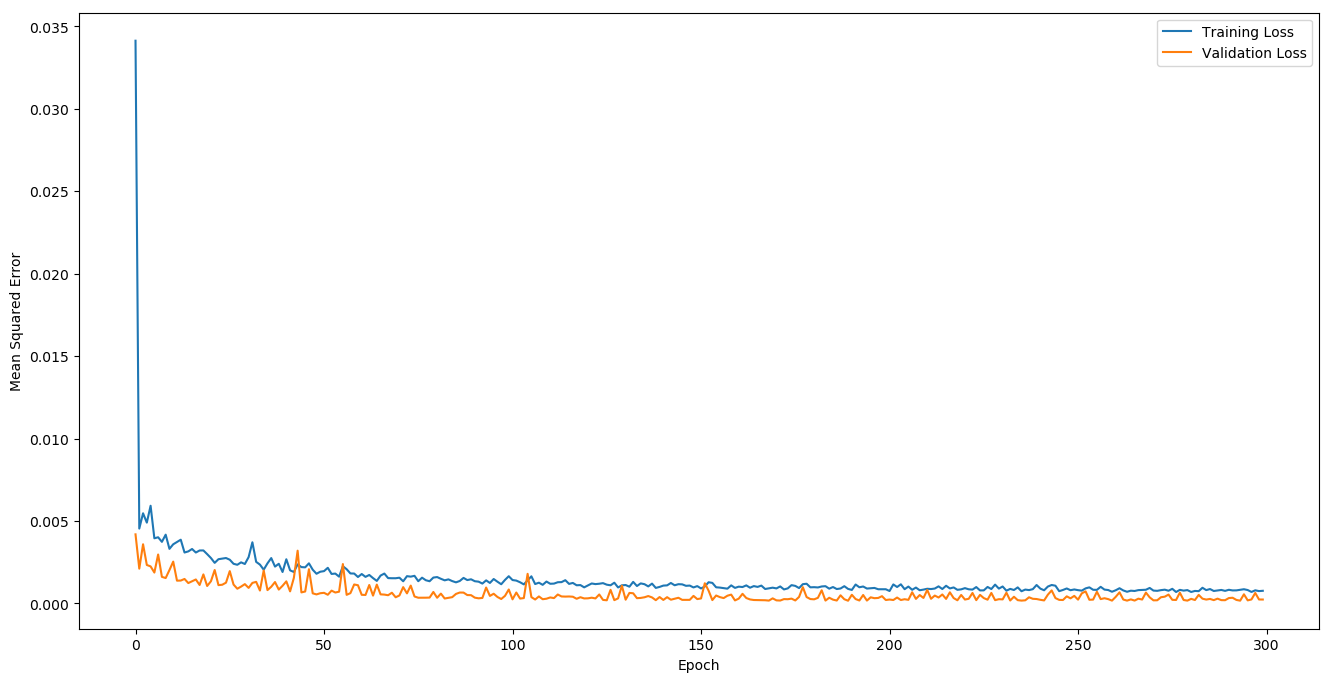

In [16]:
## visualising training history
fig, ax = plt.subplots(figsize=(16,8))

ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_xlabel('Epoch')
ax.set_ylabel('Mean Squared Error')
ax.legend(['Training Loss', 'Validation Loss'])

plt.show()

In [18]:
total_data = pd.concat((train, test), axis=0) ## conveniet to access past time_steps=60 values

test_indices = test_indices = [i for i in range(len(total_data)) if total_data.index[i].year == 2017] ## indices for year = 2017

inputs = total_data[min(test_indices)-time_steps:].values ## only the data required for inputs
inputs = inputs.reshape(-1,1)

inputs = scaler.transform(inputs) ## normalizing because model is trained on normalized data

## feature input

X_test = list()
for i in range(time_steps, len(inputs)):
    X_test.append(inputs[i-time_steps:i,0].reshape(time_steps))
    
X_test = np.array(X_test)

## adding dimension to X_test for compatibilty

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

C:\Users\abhin\anaconda3\envs\nlp_course\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


In [19]:
X_test.shape

(20, 120, 1)

In [20]:
## making predictions

preds = regressor.predict(X_test)

In [21]:
preds

array([[0.9229459 ],
       [0.91909707],
       [0.9281941 ],
       [0.92773694],
       [0.9358478 ],
       [0.9485313 ],
       [0.9529035 ],
       [0.9504635 ],
       [0.9521219 ],
       [0.9539096 ],
       [0.95401675],
       [0.9529095 ],
       [0.9522221 ],
       [0.95395434],
       [0.95506257],
       [0.96701187],
       [0.9770822 ],
       [0.9847879 ],
       [0.98630697],
       [0.97139674]], dtype=float32)

In [22]:
## inverse normalizing preds

preds = scaler.inverse_transform(preds)

In [23]:
preds

array([[775.2588 ],
       [773.1898 ],
       [778.08   ],
       [777.8343 ],
       [782.19434],
       [789.0125 ],
       [791.3628 ],
       [790.05115],
       [790.9427 ],
       [791.9036 ],
       [791.96124],
       [791.366  ],
       [790.9965 ],
       [791.9277 ],
       [792.52344],
       [798.9469 ],
       [804.3603 ],
       [808.50256],
       [809.31915],
       [801.304  ]], dtype=float32)

In [24]:
## adding to test

test['Preds'] = preds

In [25]:
test

,Open,Preds
Date,,
2017-01-03,778.81,775.258789
2017-01-04,788.36,773.189819
2017-01-05,786.08,778.080017
2017-01-06,795.26,777.834290
2017-01-09,806.40,782.194336
2017-01-10,807.86,789.012512
2017-01-11,805.00,791.362793
2017-01-12,807.14,790.051147
2017-01-13,807.48,790.942688


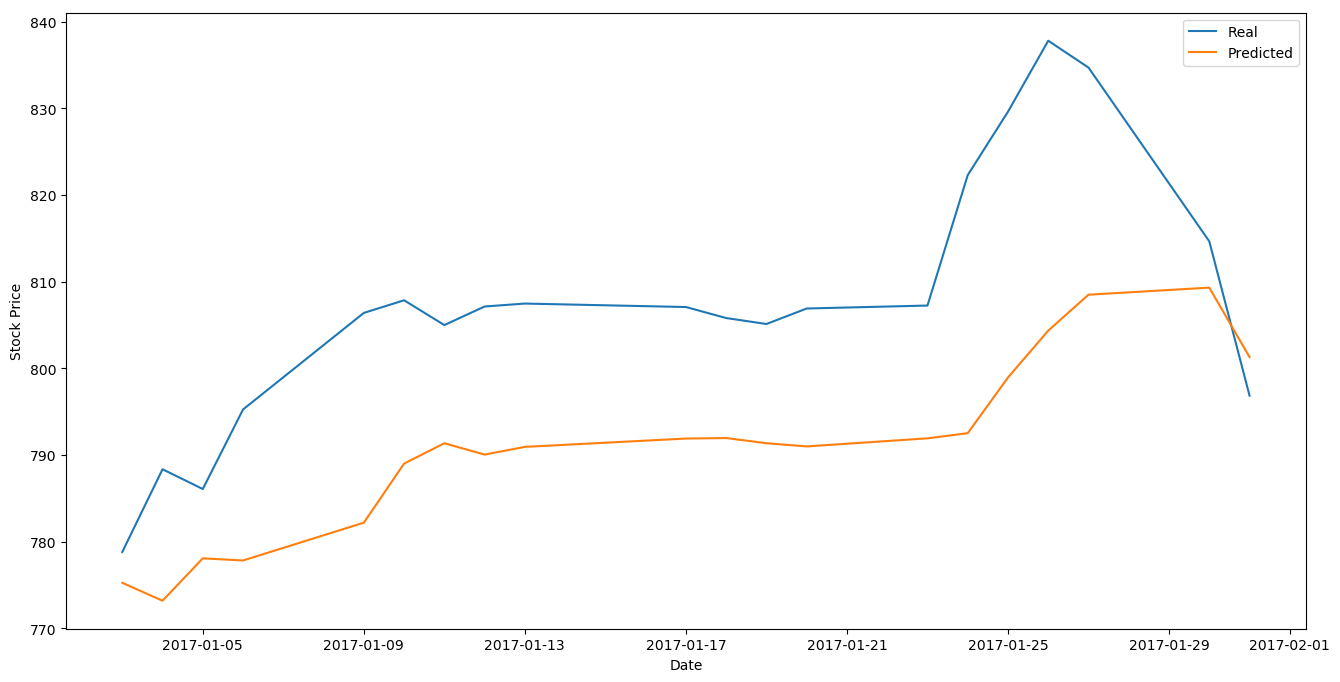

In [26]:
## visualising results

fig, ax = plt.subplots(figsize=(16,8))

ax.plot(test['Open'])
ax.plot(test['Preds'])
ax.set_xlabel('Date')
ax.set_ylabel('Stock Price')
ax.legend(['Real', 'Predicted'])

plt.show()

In [27]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [28]:
print(f"Mean Absolute Error: {mean_absolute_error(test['Open'],test['Preds'])}")

Mean Absolute Error: 16.918509521484367


In [29]:
print(f"Root Mean Squared Error: {mean_squared_error(test['Open'],test['Preds'])**(1/2)}")

Root Mean Squared Error: 18.819925241283812


In [30]:
print(f"R-Squared Score: {r2_score(test['Open'],test['Preds'])}")

R-Squared Score: -0.6296592893605679


In [33]:
tensorflow.keras.models.save_model(regressor, 'GoogleStockPrice_LSTM_BatchSize32_Epochs400_R2Score67.h5')